In [1]:
%matplotlib widget
from pathlib import Path
import sys
import os
base_path = Path(os.path.abspath('')).parent
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append(str(base_path))
import torch
from modules.tensor_nerf import TensorNeRF
from fields.listrf import ListRF
from samplers.nerf_acc import NerfAccSampler
from icecream import ic

import math
import imageio

import matplotlib.pyplot as plt


def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im.copy())
    plt.close()
    display(fig.figure)

Warp 0.6.2 initialized:
   CUDA Toolkit: 11.5, Driver: 12.0
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce RTX 3090 (sm_86)
   Kernel cache: /home/dronelab/.cache/warp/0.6.2


In [2]:
def make_rot(theta):
    return torch.tensor([
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1]
    ])

log_dir = Path("../log") / "noprednorms_nl0_conserve_pb0"
ckpt = log_dir / 'car_v38' / 'car_v38.th'
ckpt1 = '../log/shinyball_v38_conserve/shinyball_v38_conserve.th'
ckpt2 = '../log/car_v38_freezelayers_sd1e-4_dscale10/car_v38_freezelayers_sd1e-4_dscale10.th'

tensorf1 = TensorNeRF.load(torch.load(ckpt1), near_far=[2, 6], strict=False)
tensorf2 = TensorNeRF.load(torch.load(ckpt2), near_far=[2, 6], strict=False)
tensorf = tensorf1
tensorf.bg_module = tensorf2.bg_module
device = torch.device('cuda')

tensorf = tensorf.to(device)

ic| grid_size: [tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0')]
ic| self.N_voxel_list: [347217, 1279813, 3167271, 6346304, 11153628, 17925958, 27000000]
ic| self.use_predicted_normals: False
    self.align_pred_norms: True
    self.orient_world_normals: True


grid size tensor([300, 300, 300])
aabb tensor([-3., -3., -3.,  3.,  3.,  3.], device='cuda:0')
sampling step size:  tensor(0.0100)
sampling number:  1036


ic| grid_size: [tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0')]
ic| self.N_voxel_list: [347217, 1279813, 3167271, 6346304, 11153628, 17925958, 27000000]
ic| self.use_predicted_normals: False
    self.align_pred_norms: True
    self.orient_world_normals: True


grid size tensor([300, 300, 300])
aabb tensor([-1.5000, -1.5000, -1.5000,  1.5000,  1.5000,  1.5000], device='cuda:0')
sampling step size:  tensor(0.0050)
sampling number:  1036


In [3]:


from dataLoader.ray_utils import get_ray_directions, get_rays
from renderer import chunk_renderer, BundleRender
import numpy as np

w = 800
h = 800
camera_angle_x = 0.6194058656692505

fx = 0.5 * w / np.tan(0.5 * camera_angle_x)  # original focal length
fy = fx

directions = get_ray_directions(h, w, [fx,fy])  # (h, w, 3)
directions = directions / torch.norm(directions, dim=-1, keepdim=True)
c2w = torch.eye(4)
blender2opencv = torch.tensor([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]).float()

c2w = torch.tensor([
    [
        -0.9999021291732788,
        0.004192245192825794,
        -0.013345719315111637,
        -0.05379832163453102
    ],
    [
        -0.013988680206239223,
        -0.2996590733528137,
        0.95394366979599,
        3.845470428466797
    ],
    [
        -4.6566125955216364e-10,
        0.9540371894836426,
        0.29968830943107605,
        1.2080823183059692
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv
# c2w = torch.tensor([
#     [
#         0.24868656694889069,
#         -0.6090989112854004,
#         0.7530957460403442,
#         3.0358264446258545
#     ],
#     [
#         0.9685839414596558,
#         0.1563878208398819,
#         -0.1933593899011612,
#         -0.7794567346572876
#     ],
#     [
#         -7.450580152834618e-09,
#         0.7775223851203918,
#         0.6288550496101379,
#         2.5349960327148438
#     ],
#     [
#         0.0,
#         0.0,
#         0.0,
#         1.0
#     ]
# ]) @ blender2opencv

c2w = torch.tensor([
    [
        0.8443264365196228,
        -0.2852588891983032,
        0.45358625054359436,
        1.8284648656845093
    ],
    [
        0.5358295440673828,
        0.4494929313659668,
        -0.7147326469421387,
        -2.8811798095703125
    ],
    [
        1.4901164746561335e-08,
        0.8465123176574707,
        0.5323687791824341,
        2.146047353744507
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv


# c2w = torch.tensor([
#     [
#         -0.24868960678577423,
#         0.6655282974243164,
#         -0.7037226557731628,
#         -2.836796998977661
#     ],
#     [
#         -0.9685831665992737,
#         -0.17087841033935547,
#         0.18068504333496094,
#         0.7283647656440735
#     ],
#     [
#         0.0,
#         0.7265485525131226,
#         0.6871150732040405,
#         2.7698497772216797
#     ],
#     [
#         0.0,
#         0.0,
#         0.0,
#         1.0
#     ]
# ]) @ blender2opencv

# c2w = torch.tensor([
#     [
#         0.6845461130142212,
#         -0.24688588082790375,
#         0.6858890652656555,
#         2.7649075984954834
#     ],
#     [
#         0.7289695143699646,
#         0.23184067010879517,
#         -0.644091010093689,
#         -2.596414089202881
#     ],
#     [
#         -1.4901159417490817e-08,
#         0.9409023523330688,
#         0.33867788314819336,
#         1.365254282951355
#     ],
#     [
#         0.0,
#         0.0,
#         0.0,
#         1.0
#     ]
# ]) @ blender2opencv




rays_o, rays_d = get_rays(directions, c2w)  # both (h*w, 3)

rays = torch.cat([rays_o, rays_d], 1).to(device)

/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Module brdf_samplers.equirect_bright_sampler load on device 'cuda:0' took 1.31 ms


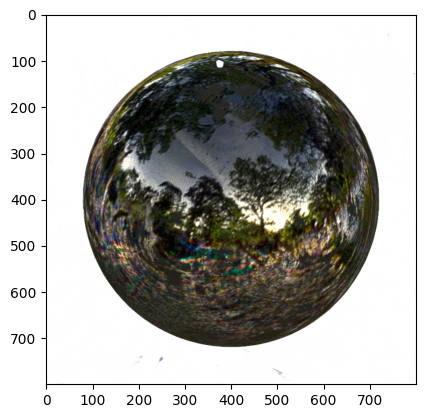

In [4]:
torch.cuda.empty_cache()
tensorf.model.max_retrace_rays=[300000]
tensorf.model.max_brdf_rays=[500000, 500000]
tensorf.eval_batch_size=5000
tensorf.model.russian_roulette = True


brender = BundleRender(chunk_renderer, h, w, 1)
ims, stats = brender(rays, tensorf, N_samples=-1, ndc_ray=False, is_train=False)
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))

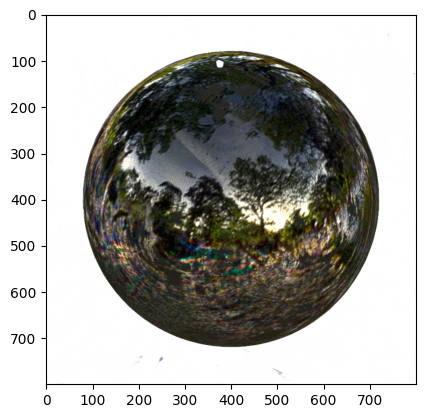

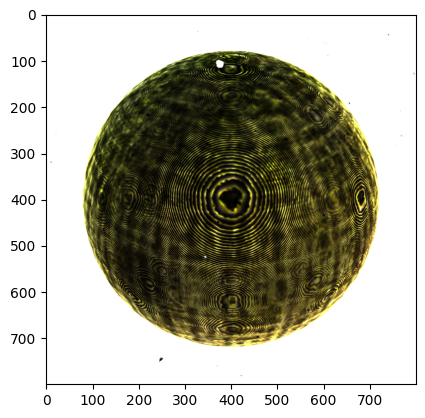

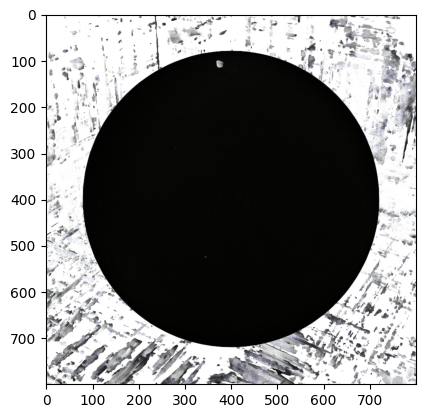

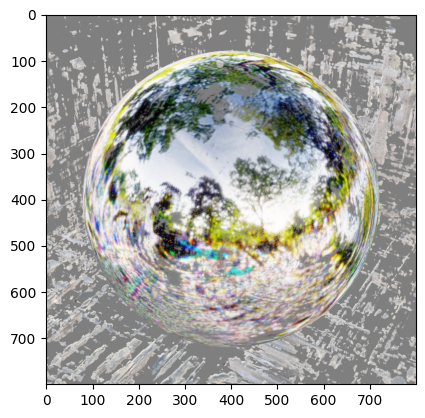

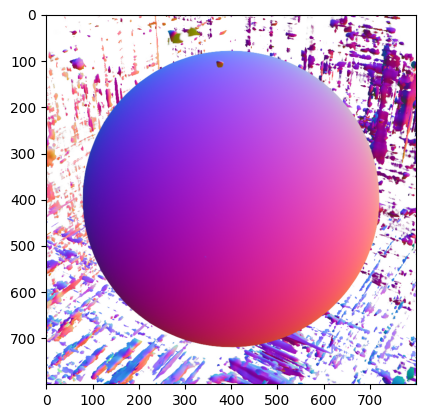

In [5]:
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['diffuse'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['tint'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['spec'] / (ims['spec']+1)*255).numpy().astype(np.uint8))
disp_im((ims['world_normal']*127 + 128).numpy().astype(np.uint8))

In [6]:
base = Path('../rotating_ball')
i = 0
brender = BundleRender(chunk_renderer, h, w, 1)

base.mkdir(exist_ok=True, parents=True)
for i, theta in enumerate(np.linspace(0, 2*np.pi, 200)):
    tensorf.bg_module.R = make_rot(theta).to(device)
    ims, stats = brender(rays, tensorf, N_samples=-1, ndc_ray=False, is_train=False)

    im = (ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8)
    imageio.imwrite(base / f'{i:03d}.png', im)